# MNIST Multi-Modal Learning Practice Notebook

In this notebook, you will practice some of the core concepts we have presented. The overall pipeline is as follows:

---

## 1. Data Preparation

- Load the **MNIST** dataset.
- Split the dataset into **train**, **validation**, and **test** sets.
- Horizontally split each image into **upper** and **lower** halves.
- Pad the removed half with zeros to maintain consistent input shapes.

---

## 2. Model Definitions

Define three encoders:

1. **CNNEncoder**  
   - A simple CNN with two convolutional layers and pooling layers.

2. **MLPEncoder**  
   - A simple MLP with two fully connected layers.

3. **FusedModel**  
   - A combined model using:
     - `CNNEncoder` for the **upper half**.
     - `MLPEncoder` for the **lower half**.

---

## 3. Training and Evaluation

For each encoder:

### (i) CNNEncoder

- Use only the **upper half** of the input data.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (ii) MLPEncoder

- Use only the **lower half** of the input data.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (iii) FusedModel

- Use **both upper and lower halves** of the input data.
- Use the CNNEncoder (upper half) and the MLPEncoder (bottom half) and use concatenation to fuse the representations.
- Train for **5 epochs**.
- Validate using the validation set.
- Evaluate performance on the test set.

### (iv) Different Fusion Stategies
- Explore alternative fusion strategies such as for instance average fusion (Averaging representations).

### (v) Investigate how adding noise to the representations impacts performance
- Add increasing amounts of noise to one or both modalities and monitor performance.
- Visualize the fused representations using PCA or t-SNE.

---
Concepts introduced tomorrow:

### (vi) Self-supervised:
- Instead of directly fusing modalities, align the modalities using CLIP.
- Visualize the fused representations using PCA or t-SNE.
- Train a linear classifier on-top of the learned representations (keeping the encoders frozen).

### (vii) Alignment noise:
- Add increasing amounts of noise to one or both modalities and monitor performance.
- Visualize the fused representations using PCA or t-SNE.

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F


# Set hyperparams and load, split MNIST

In [2]:
# Hyperparameters
batch_size = 64
learning_rate = 0.01
num_epochs = 5
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# Load MNIST dataset

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.7, 0.3])
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Visualize some images

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in train_loader:
    # Visualize the first few images in the batch
    num_images_to_show = 5
    for i in range(num_images_to_show):
        image = images[i]  # Get one image from the batch
        image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

        # Display the image
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {labels[i].item()}')
        plt.axis('off')  # Turn off axis labels
        plt.show()

    break  # Exit the loop after visualizing the first batch

# Define our models - a CNN, an MLP, and a FusedModel

In [19]:
class CNNEncoder(nn.Module):
    """Simple CNN Encoder"""
    def __init__(self):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64*7*7, 10) #This shape depends on the kernels and the input (split) shape

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x[0]))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x
    
    def inner_features(self, x: torch.Tensor) -> torch.Tensor:
        """Extract inner features from the input tensor."""
        x = F.relu(self.conv1(x[0]))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        return x

class MLP(nn.Module):
    """Simple 2-Layer MLP"""
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x[1].view(x[1].size(0), -1))) #Flatten all dimensions except batch_size
        x = F.relu(self.fc2(x))
        return x
    
    def inner_features(self, x: torch.Tensor) -> torch.Tensor:
        """Extract inner features from the input tensor."""
        x = F.relu(self.fc1(x[1].view(x[1].size(0), -1))) #Flatten all dimensions except batch_size
        return x

# Fusing representations
class FusedModel(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModel, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLP()
        self.fc = nn.Linear(20, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn_encoder(x)
        mlp_out = self.mlp_encoder(x)
        fused = torch.cat((cnn_out, mlp_out), dim=1)
        return self.fc(fused)

# Utils

In [20]:
import torch.nn.functional as F

def prepare_data(data):
    """Splits MNIST images into two halves horizontally and pads to original shape."""
    upper_half = data[:, :, :14, :]  # Top half: [B, 1, 14, 28]
    lower_half = data[:, :, 14:, :]  # Bottom half: [B, 1, 14, 28]

    # Pad bottom 14 rows with zeros for upper_half
    upper_half_padded = F.pad(upper_half, pad=(0, 0, 0, 14))  # Pad rows: (left, right, top, bottom)

    # Pad top 14 rows with zeros for lower_half
    lower_half_padded = F.pad(lower_half, pad=(0, 0, 14, 0))  # Pad rows: (left, right, top, bottom)

    return upper_half_padded, lower_half_padded


def train_model(model: nn.Module, data_loader, optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss, device: torch.device):
    """Train the model."""
    model.train()
    total_loss = 0.0
    
    for i, (images, labels) in enumerate(data_loader):
        optimizer.zero_grad()
        upper_half, lower_half = prepare_data(images)
        upper_half = upper_half.to(device)
        lower_half = lower_half.to(device)
        labels = labels.to(device)

        outputs = model((upper_half, lower_half))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images[0].size(0)
        #print(f"Batch {i}: Loss = {loss.item()}")
    return total_loss / len(data_loader.dataset)


def evaluate_model(model: nn.Module, data_loader, criterion, device: torch.device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for (images, labels) in data_loader:
            upper_half, lower_half = prepare_data(images)
            upper_half = upper_half.to(device)
            lower_half = lower_half.to(device)
            labels = labels.to(device)  # Move labels to device

            outputs = model((upper_half, lower_half))
            loss = criterion(outputs, labels)

            total_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = correct / total
    return avg_loss, accuracy

In [5]:
for images, _ in train_loader:
  upper_half, lower_half = prepare_data(images)
  print(upper_half.shape, lower_half.shape)
  print(images.shape)
  break

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 28, 28])
torch.Size([64, 1, 28, 28])


# Check that split works

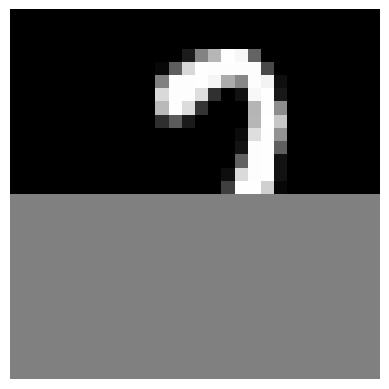

In [8]:
#Look at the first upper_half image
image = upper_half[0]  # Get one image from the batch
image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()



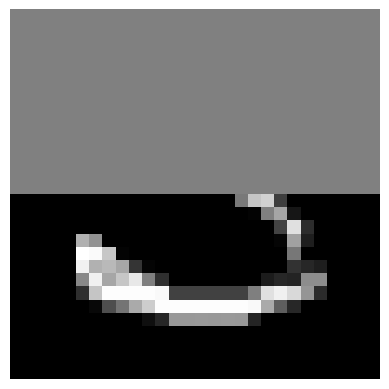

In [19]:
#Look at the first lower_half image
image = lower_half[0]  # Get one image from the batch
image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()

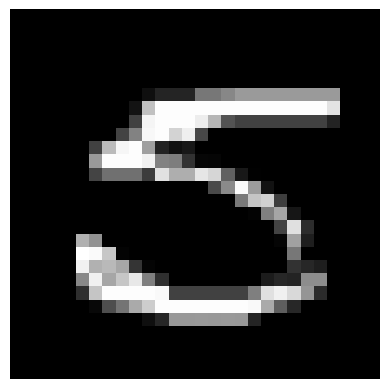

In [20]:
#look at first full image
image = images[0]
image = np.transpose(image, (1, 2, 0))  # Rearrange dimensions from CxHxW to HxWxC

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis labels
plt.show()



# Init and train CNN

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [10]:
#Initialize CNN
cnn_encoder = CNNEncoder()
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_encoder.parameters(), lr=learning_rate)
cnn_encoder.to(device)

CNNEncoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=3136, out_features=10, bias=True)
)

In [11]:
# Train and evaluate the CNN encoder
for epoch in range(num_epochs):
    avg_loss = train_model(cnn_encoder, train_loader, cnn_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: CNN Encoder train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(cnn_encoder, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: CNN Encoder val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(cnn_encoder, test_loader, criterion, device=device)
print(f"CNN Encoder test loss {avg_loss}, accuracy {accuracy:.4f}")

Epoch 1: CNN Encoder train loss 0.007456954736439955
Epoch 1: CNN Encoder val loss 0.31328244144717854, accuracy 0.9018
Epoch 2: CNN Encoder train loss 0.0047920311668089455
Epoch 2: CNN Encoder val loss 0.29500186036692727, accuracy 0.9057
Epoch 3: CNN Encoder train loss 0.004613782350683496
Epoch 3: CNN Encoder val loss 0.284083340883255, accuracy 0.9086
Epoch 4: CNN Encoder train loss 0.004311020391150599
Epoch 4: CNN Encoder val loss 0.2794670794539981, accuracy 0.9117
Epoch 5: CNN Encoder train loss 0.00415596181225209
Epoch 5: CNN Encoder val loss 0.29409962191846634, accuracy 0.9064
Done training! Evaluating on test set...
CNN Encoder test loss 0.2704895228385925, accuracy 0.9103


# Init and train MLP

In [12]:
#Initialize MLP
mlp = MLP()
criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.Adam(mlp.parameters(), lr=learning_rate)
mlp.to(device)

# Train and evaluate the MLP
for epoch in range(num_epochs):
    avg_loss = train_model(mlp, train_loader, mlp_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: MLP train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(mlp, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: MLP val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(mlp, test_loader, criterion, device=device)
print(f"MLP test loss {avg_loss}, accuracy {accuracy:.4f}")

Epoch 1: MLP train loss 0.02773515165135974
Epoch 1: MLP val loss 1.7524439165327284, accuracy 0.2792
Epoch 2: MLP train loss 0.026802735402470544
Epoch 2: MLP val loss 1.7220430903964572, accuracy 0.2917
Epoch 3: MLP train loss 0.026591129200799125
Epoch 3: MLP val loss 1.7182743078867595, accuracy 0.2893
Epoch 4: MLP train loss 0.026443898955980937
Epoch 4: MLP val loss 1.6948569176991781, accuracy 0.2944
Epoch 5: MLP train loss 0.026414682947454
Epoch 5: MLP val loss 1.6918685295316909, accuracy 0.2927
Done training! Evaluating on test set...
MLP test loss 1.682537137413025, accuracy 0.2972


# Init and train FusedModel

In [13]:
#Initialize Fusion Encoder
fused_nn = FusedModel()
criterion = nn.CrossEntropyLoss()
fuse_optimizer =  optim.Adam(fused_nn.parameters(), lr=learning_rate)
fused_nn.to(device)


FusedModel(
  (cnn_encoder): CNNEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=10, bias=True)
  )
  (mlp_encoder): MLP(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (fc): Linear(in_features=20, out_features=10, bias=True)
)

In [14]:
# Train and evaluate the Fused encoder
for epoch in range(num_epochs):
    avg_loss = train_model(fused_nn, train_loader, fuse_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(fused_nn, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(fused_nn, test_loader, criterion, device=device)
print(f"Fusion Encoder test loss {avg_loss}, accuracy {accuracy:.4f}")

Epoch 1: Fusion Encoder train loss 0.005656766788856614
Epoch 1: Fusion Encoder val loss 0.20919932531317076, accuracy 0.9400
Epoch 2: Fusion Encoder train loss 0.0028697318988186974
Epoch 2: Fusion Encoder val loss 0.16039971411890452, accuracy 0.9511
Epoch 3: Fusion Encoder train loss 0.002510646524639534
Epoch 3: Fusion Encoder val loss 0.14675224485662247, accuracy 0.9585
Epoch 4: Fusion Encoder train loss 0.0022608802577347626
Epoch 4: Fusion Encoder val loss 0.14241304373410013, accuracy 0.9584
Epoch 5: Fusion Encoder train loss 0.0020517527315033865
Epoch 5: Fusion Encoder val loss 0.1471181207464801, accuracy 0.9571
Done training! Evaluating on test set...
Fusion Encoder test loss 0.13777706570625306, accuracy 0.9615


## (iv) Different Fusion Stategies


In [21]:
class FusedModel1(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModel1, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLP()
        self.fc = nn.Linear(64*7*7 + 128, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn_encoder.inner_features(x)
        mlp_out = self.mlp_encoder.inner_features(x)
        # average the two representations
        x = torch.cat((cnn_out, mlp_out), dim=1)
        fused = self.fc(x)
        return fused

In [16]:
class FusedModel2(nn.Module):
    #Implement this in practical
    """Model that fuses CNN and MLP representations."""
    def __init__(self):
        super(FusedModel2, self).__init__()
        self.cnn_encoder = CNNEncoder()
        self.mlp_encoder = MLP()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn_encoder(x)
        mlp_out = self.mlp_encoder(x)
        # select the maximum of the two representations
        fused = torch.max(cnn_out, mlp_out)
        return fused

In [22]:
fused_nn = FusedModel1()
criterion = nn.CrossEntropyLoss()
fuse_optimizer =  optim.Adam(fused_nn.parameters(), lr=learning_rate)
fused_nn.to(device)


FusedModel1(
  (cnn_encoder): CNNEncoder(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fc1): Linear(in_features=3136, out_features=10, bias=True)
  )
  (mlp_encoder): MLP(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
  (fc): Linear(in_features=3264, out_features=10, bias=True)
)

In [23]:
# Train and evaluate the Fused encoder
for epoch in range(num_epochs):
    avg_loss = train_model(fused_nn, train_loader, fuse_optimizer, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder train loss {avg_loss}")
    avg_loss, accuracy = evaluate_model(fused_nn, val_loader, criterion, device=device)
    print(f"Epoch {epoch+1}: Fusion Encoder val loss {avg_loss}, accuracy {accuracy:.4f}")

print("Done training! Evaluating on test set...")
#Test
avg_loss, accuracy = evaluate_model(fused_nn, test_loader, criterion, device=device)
print(f"Fusion Encoder test loss {avg_loss}, accuracy {accuracy:.4f}")

Epoch 1: Fusion Encoder train loss 0.0045247434695206935
Epoch 1: Fusion Encoder val loss 0.23469054387178687, accuracy 0.9293
Epoch 2: Fusion Encoder train loss 0.0024358755221723445
Epoch 2: Fusion Encoder val loss 0.1373283449014028, accuracy 0.9592
Epoch 3: Fusion Encoder train loss 0.002255846948895071
Epoch 3: Fusion Encoder val loss 0.13401362885534762, accuracy 0.9608
Epoch 4: Fusion Encoder train loss 0.001996168175800925
Epoch 4: Fusion Encoder val loss 0.14508918918503655, accuracy 0.9559
Epoch 5: Fusion Encoder train loss 0.0019409410678947877
Epoch 5: Fusion Encoder val loss 0.14856585454609658, accuracy 0.9584
Done training! Evaluating on test set...
Fusion Encoder test loss 0.1254173233255744, accuracy 0.9630


## (v) Investigate how adding noise to the representations impacts performance

## (vi) Self-supervised

## (vii) Alignment noise